#  Trouble with Longitudinal Studies

This notebook covers challenges that arise from analyzing longitudinal data. 

Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4310506/

Consider the following social navigation setup. The variables are:

* A_0: initial robot behavior mode 
* L_1: pedestrian behavior cues
* A_1: robot behavior adjustment
* Y: final pedestrian impression
* U: unobserved factors intrinsic to the pedestrian

We assumed a particular scenario where in fact, the final pedestrian impression is only affected by the unobserved factors and none of the robot behavior patterns $A_0, A_1$ actually influence the outcome of the final pedestrian impression. Then, under this assumption, the difference in the outcome between robots always taking action $A_0 = A_1 = 1$ versus always taking $A_0 = A_1 = 0$ is zero:


$$ {\mathbb{E}[Y(A_0 = 1, A_1 = 1)]} - {\mathbb{E}[Y(A_0 = 0, A_1 = 0)]} = 0$$



In [14]:
import pandas as pd
from causal_hri import data
from causal_hri import estimators
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
from ananke.graphs import DAG
np.random.seed(12341)

We first reproduce Figure 8 from the paper:

In [15]:
g = DAG(vertices=['A_0', 'L_1', 'A_1', 'U', 'Y'],
       di_edges=[('A_0', 'L_1'), ('L_1', 'A_1'), ('U', 'L_1'), ('U', 'Y')])

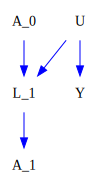

In [16]:
g.draw()

In [17]:
df = data.generate_longitudinal_fail_dataset(N=1000)

In [18]:
df.head()

A_0  A_1  Y  L_1
0    1    1  0    1
1    1    1  1    1
2    0    0  1    0
3    0    1  1    1
4    0    0  0    0

A common approach to modeling such a scenario is to use a regression model to understand how the robot actions $A_0, A_1$ affect the outcome $Y$.

In [19]:
reg = linear_model.LogisticRegression(penalty='none')
reg = reg.fit(X=df[["A_0", "A_1"]].values, y=df["Y"].values)

When we inspect the regression coefficients for $A_0, A_1$ we find that they are not zero, as shown below: 

In [20]:
reg.coef_

array([[-0.42306028,  1.168475  ]])

If we were to use this model to predict how the robot actions would affect the outcome we would wrongly conclude that 
$\mathbb{E}[Y(a_0 = 1, a_1 = 1)]  -  \mathbb{E}[Y(a_0 = 0, a_1 = 0)]$ is not equal to 0:

In [21]:
reg.predict_proba(np.array([[0, 0]]))[0, 1] - reg.predict_proba(np.array([[1, 1]]))[0, 1]

-0.18412914425417243

Running a larger simulation study shows that the distribution of estimated effects under multiple datasets is centered well away from the true value of 0. A statistical test with the null hypothesis being that there is no effect may have been rejected under these results, leading an analyst to wrongly conclude that the robot actions do in fact impact the outcome. In the subsequent notebook, we will explore how to deal with this issue.

In [22]:
regression = []
n_datasets = 100
N = 1000
for i in range(n_datasets):
    df = df = data.generate_longitudinal_fail_dataset(N=N)
    reg = linear_model.LogisticRegression(penalty='none')
    reg = reg.fit(X=df[["A_0", "A_1"]].values, y=df["Y"].values)
    p_1_0 = reg.predict_proba(np.array([[0, 0]]))[0, 1]
    p_1_1=reg.predict_proba(np.array([[1, 1]]))[0, 1]
    #regression_estimate = estimators.compute_log_odds_ratio(p_1_0=reg.predict_proba(np.array([[0, 0]]))[0, 1], 
                                  #p_1_1=reg.predict_proba(np.array([[1, 1]]))[0, 1])
    regression_estimate = p_1_1 - p_1_0
    regression.append((regression_estimate))

In the following plot, note how the boxplot is centered well away from 0:

{'whiskers': [<matplotlib.lines.Line2D at 0x13aabc0d0>,
 'caps': [<matplotlib.lines.Line2D at 0x13aabc670>,
 'boxes': [<matplotlib.lines.Line2D at 0x13aa94ee0>],
 'medians': [<matplotlib.lines.Line2D at 0x13aabcc10>],
 'fliers': [<matplotlib.lines.Line2D at 0x13aabcee0>],
 'means': []}

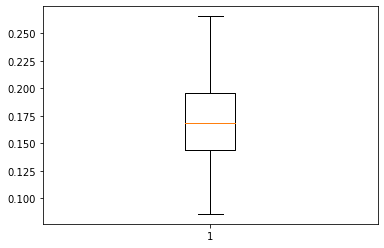

In [23]:
plt.boxplot(regression)

Why does the estimator give the incorrect answer? When we condition on $A_0$ and $A_1$, we open up a collider path. The collider in question is $L_0$, and $A_1$ is a descendant of that collider. This induces a spurious correlation between the outcome $Y$ and the actions $A_0, A_1$, even when no causal relationship is present.

